In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/googlenewsvectors/GoogleNews-vectors-negative300.bin
/kaggle/input/2-recommended-reads-conversion-of-data-to-num/__results__.html
/kaggle/input/2-recommended-reads-conversion-of-data-to-num/vectorizedData.csv
/kaggle/input/2-recommended-reads-conversion-of-data-to-num/__notebook__.ipynb
/kaggle/input/2-recommended-reads-conversion-of-data-to-num/__output__.json
/kaggle/input/2-recommended-reads-conversion-of-data-to-num/custom.css
/kaggle/input/2-recommended-reads-conversion-of-data-to-num/__results___files/__results___9_0.png


LSTM SimpleRNN Embedding


In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, LSTM, SimpleRNN, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Step 1: Prepare the data
max_title_length = 50
max_author_length = 50
max_desc_length = 200
num_classes = 10
# Load the data
dataset = pd.read_csv("/kaggle/input/2-recommended-reads-conversion-of-data-to-num/vectorizedData.csv")
dataset = dataset.drop_duplicates(subset=['booktitle', 'authorname'], keep='first')

# Assuming you have a dataset object containing your data
# Split the data into input (X) and output (y) variables
X = dataset[['booktitle', 'authorname', 'bookdescription']].values
y = dataset['type'].values

# Tokenize and pad the input sequences
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X[:, 0])  # title
tokenizer.fit_on_texts(X[:, 1])  # author
tokenizer.fit_on_texts(X[:, 2])  # description

title_sequences = tokenizer.texts_to_sequences(X[:, 0])
title_sequences = pad_sequences(title_sequences, maxlen=max_title_length)
author_sequences = tokenizer.texts_to_sequences(X[:, 1])
author_sequences = pad_sequences(author_sequences, maxlen=max_author_length)
desc_sequences = tokenizer.texts_to_sequences(X[:, 2])
desc_sequences = pad_sequences(desc_sequences, maxlen=max_desc_length)

# Encode the target labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
encoded_labels = to_categorical(encoded_labels)

# Split the data into training and testing sets
train_title, test_title, train_author, test_author, train_desc, test_desc, train_labels, test_labels = \
    train_test_split(title_sequences, author_sequences, desc_sequences, encoded_labels, test_size=0.2, random_state=42)

# Step 2: Build the model
title_input = Input(shape=(max_title_length,))
title_embedded = Embedding(len(tokenizer.word_index) + 1, 100)(title_input)
title_lstm = LSTM(128)(title_embedded)

author_input = Input(shape=(max_author_length,))
author_embedded = Embedding(len(tokenizer.word_index) + 1, 100)(author_input)
author_rnn = SimpleRNN(64)(author_embedded)

desc_input = Input(shape=(max_desc_length,))
desc_embedded = Embedding(len(tokenizer.word_index) + 1, 100)(desc_input)
desc_lstm = LSTM(128)(desc_embedded)

merged = keras.layers.concatenate([title_lstm, author_rnn, desc_lstm])
dense = Dense(128, activation='relu')(merged)
output = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs=[title_input, author_input, desc_input], outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit([train_title, train_author, train_desc], train_labels, validation_data=([test_title, test_author, test_desc], test_labels), epochs=10, batch_size=64)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Epoch 1/10
138/138 [==============================] - 82s 549ms/step - loss: 2.1995 - accuracy: 0.2621 - val_loss: 1.7051 - val_accuracy: 0.4594
Epoch 2/10
138/138 [==============================] - 74s 534ms/step - loss: 1.1811 - accuracy: 0.6367 - val_loss: 1.3530 - val_accuracy: 0.5819
Epoch 3/10
138/138 [==============================] - 74s 534ms/step - loss: 0.4361 - accuracy: 0.8678 - val_loss: 1.5325 - val_accuracy: 0.5819
Epoch 4/10
138/138 [==============================] - 75s 544ms/step - loss: 0.1228 - accuracy: 0.9668 - val_loss: 1.7717 - val_accuracy: 0.5946
Epoch 5/10
138/138 [==============================] - 75s 547ms/step - loss: 0.0320 - accuracy: 0.9930 - val_loss: 2.1499 - val_accuracy: 0.5741
Epoch 6/10
138/138 [==============================] - 77s 557ms/step - loss: 0.0142 - accuracy: 0.9980 - val_loss: 2.1752 - val_accuracy: 0.5664
Epoch 7/10
138/138 [==============================] - 76s 549ms/step - loss: 0.0040 - accuracy: 0.9997 - val_loss: 2.3843 - val_ac

In [3]:
model.save("booktypemodel.h5")

In [4]:
model = keras.models.load_model('/kaggle/working/booktypemodel.h5')

In [5]:
# Assuming you have a new input example
new_title = "Dune"
new_author = "Herbert"
new_desc = "A space journey with friends"

# Tokenize and pad the input sequences
new_title_sequence = tokenizer.texts_to_sequences([new_title])
new_title_sequence = pad_sequences(new_title_sequence, maxlen=max_title_length)
new_author_sequence = tokenizer.texts_to_sequences([new_author])
new_author_sequence = pad_sequences(new_author_sequence, maxlen=max_author_length)
new_desc_sequence = tokenizer.texts_to_sequences([new_desc])
new_desc_sequence = pad_sequences(new_desc_sequence, maxlen=max_desc_length)


In [6]:
prediction = model.predict([new_title_sequence, new_author_sequence, new_desc_sequence])


1/1 [==============================] - 1s 1s/step


In [7]:
predicted_class_index = np.argmax(prediction)


In [8]:
predicted_class = label_encoder.classes_[predicted_class_index]
predicted_class_books = dataset[dataset['type'] == predicted_class]
predicted_class

'space opera'

In [9]:
from keras.preprocessing.text import Tokenizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Step 1: Tokenize user_desc using Keras tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(predicted_class_books['bookdescription'])  # Assuming 'bookdescription' is the column name containing book descriptions
user_desc_tokens = tokenizer.texts_to_sequences([new_desc])

# Step 2: Convert user_desc_tokens to a vector representation
max_sequence_length = 100  # Define the maximum sequence length based on your data
user_desc_vector = pad_sequences(user_desc_tokens, maxlen=max_sequence_length)

# Step 3: Calculate cosine similarity between user_desc_vector and book descriptions
book_desc_vectors = tokenizer.texts_to_sequences(predicted_class_books['bookdescription'])
book_desc_vectors = pad_sequences(book_desc_vectors, maxlen=max_sequence_length)
cosine_similarities = cosine_similarity(user_desc_vector, book_desc_vectors)

# Step 4: Sort the cosine similarities and get the top 10 books
top_10_indices = np.argsort(cosine_similarities)[0][-10:][::-1]
top_10_books = predicted_class_books.iloc[top_10_indices]

# Access the desired information from the top 10 books
for _, book in top_10_books.iterrows():
    book_title = book['booktitle']
    book_description = book['bookdescription']
    book_type = book['type']
    
    # Print or use the information as needed
    print(f"Title: {book_title}")
    print(f"Description: {book_description}")
    print(f"Type: {book_type}")
    print("---------------------")


Title: The Death of Sleep
Description: THE DISASTER IN SPACE DIDN'T KILL HER - IT JUST STOLE HER LIFE
Type: space opera
---------------------
Title: The Great Dune Trilogy
Description: Herbert's evocative, epic tales are set on the desert planet Arrakis, the focus for a complex political and military struggle with galaxy-wide repercussions. This volume includes the titles 'Dune', 'Dune Messiah' and 'Children of Dune'.
Type: space opera
---------------------
Title: Polaris
Description: The national best-selling author brings back the daring Alex Benedict from A Talent for War and thrusts him into a far-future tale of mystery and suspense.
Type: space opera
---------------------
Title: Canto Bight
Description: This collection of four short stories will focus on creatures from the glamorous casino world of Canto Bight, described as the galactic version of Monaco.
Type: space opera
---------------------
Title: Lost Stars
Description: A long time ago in a galaxy far, far away…Eight years af

Epoch 1/10
138/138 [==============================] - 81s 561ms/step - loss: 0.0010 - accuracy: 0.9998 - val_loss: 2.6606 - val_accuracy: 0.5578
Epoch 2/10
138/138 [==============================] - 76s 547ms/step - loss: 5.1196e-04 - accuracy: 0.9999 - val_loss: 2.8808 - val_accuracy: 0.5642
Epoch 3/10
138/138 [==============================] - 75s 543ms/step - loss: 5.7717e-04 - accuracy: 0.9998 - val_loss: 2.9503 - val_accuracy: 0.5587
Epoch 4/10
138/138 [==============================] - 75s 542ms/step - loss: 3.7728e-04 - accuracy: 0.9999 - val_loss: 2.9225 - val_accuracy: 0.5528
Epoch 5/10
138/138 [==============================] - 75s 541ms/step - loss: 7.3724e-04 - accuracy: 0.9999 - val_loss: 2.9473 - val_accuracy: 0.5624
Epoch 6/10
138/138 [==============================] - 75s 543ms/step - loss: 1.5627e-04 - accuracy: 1.0000 - val_loss: 3.0032 - val_accuracy: 0.5574
Epoch 7/10
138/138 [==============================] - 76s 551ms/step - loss: 1.2125e-04 - accuracy: 1.0000 - v

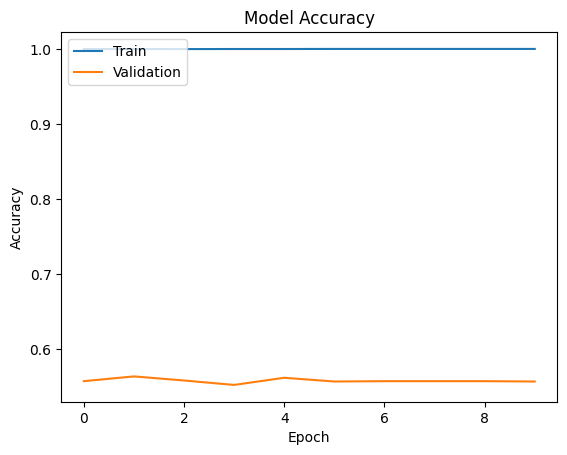

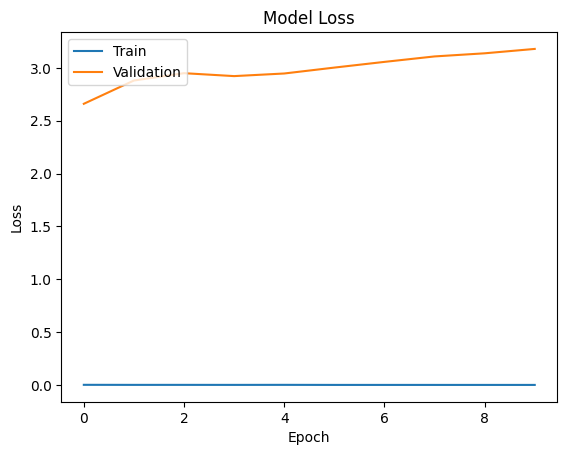

In [10]:
import matplotlib.pyplot as plt

# Train the model and store the training history
history = model.fit([train_title, train_author, train_desc], train_labels,
                    validation_data=([test_title, test_author, test_desc], test_labels),
                    epochs=10, batch_size=64)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


69/69 [==============================] - 7s 101ms/step


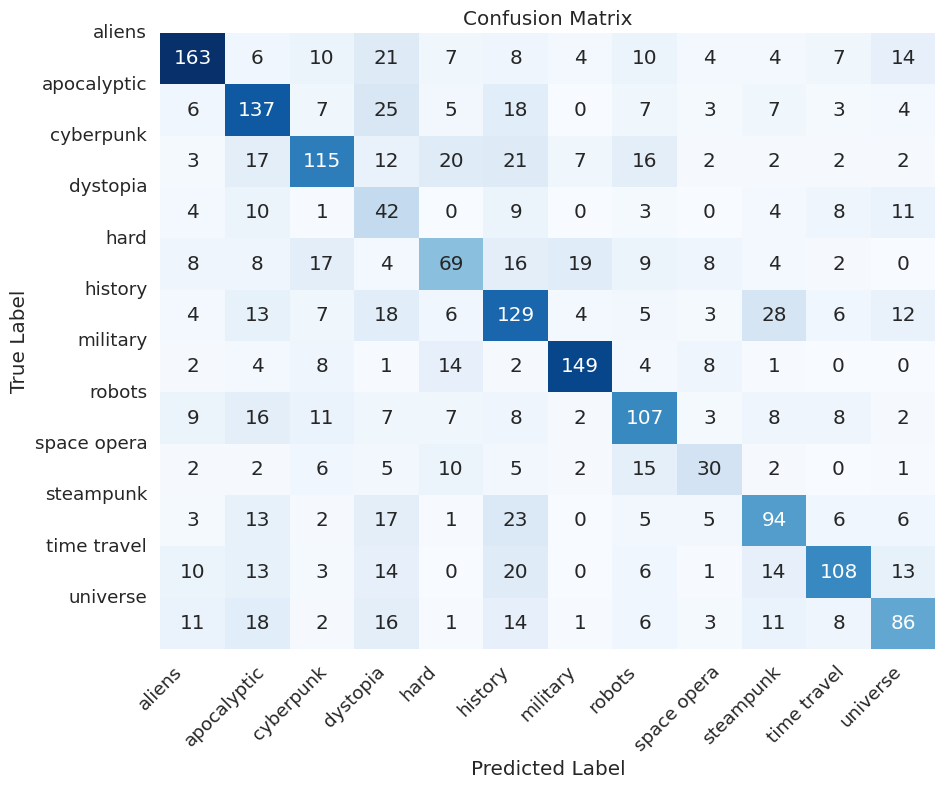

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have already trained your model and obtained predictions on the test set
predictions = model.predict([test_title, test_author, test_desc])
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a figure and axis for the plot
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# Customize the plot
class_names = label_encoder.classes_
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names, rotation=0)  # Set rotation to 0 for y-axis labels

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


In [12]:
from sklearn.metrics import classification_report

# Modelin tahminlerini yapın
y_pred = model.predict([test_title, test_author, test_desc])
# Tahminlerdeki sınıf endekslerini gerçek sınıf etiketlerine dönüştürün
y_pred_classes = np.argmax(y_pred, axis=1)
# Gerçek sınıf etiketlerini elde edin
y_true = np.argmax(test_labels, axis=1)

# Sınıflandırma raporunu hesaplayın
report = classification_report(y_true, y_pred_classes)

# Sonucu yazdırın
print(report)


69/69 [==============================] - 7s 102ms/step
              precision    recall  f1-score   support

           0       0.72      0.63      0.67       258
           1       0.53      0.62      0.57       222
           2       0.61      0.53      0.56       219
           3       0.23      0.46      0.31        92
           4       0.49      0.42      0.45       164
           5       0.47      0.55      0.51       235
           6       0.79      0.77      0.78       193
           7       0.55      0.57      0.56       188
           8       0.43      0.38      0.40        80
           9       0.53      0.54      0.53       175
          10       0.68      0.53      0.60       202
          11       0.57      0.49      0.52       177

    accuracy                           0.56      2205
   macro avg       0.55      0.54      0.54      2205
weighted avg       0.58      0.56      0.56      2205

